# MobileNetV2 model 
## outline of the code

1. Import necessary libraries:
* Import TensorFlow, Keras, and other necessary libraries for building and training the model.

2. Load the dataset:
* Load the face mask dataset, which includes images of people with and without masks.

3. Data preprocessing:

* Resize the images to a consistent size (e.g., 224x224 pixels) and normalize the pixel values.
* Apply data augmentation techniques (e.g., rotation, flipping, zooming) to artificially increase the size and diversity of the dataset.
* Split the dataset into training and test sets for model evaluation.

4. Create a base model with transfer learning:

* Load a pre-trained model (MobileNetV2) as the base model.
* Remove the top layers to use the pre-trained model as a feature extractor.

5. Add regularization and custom layers:

* Apply regularization techniques (dropout) to reduce overfitting.
* Add custom layers on top of the base model to create a new model architecture tailored for the face mask classification task.

6. Compile the model:

* Compile the model with an optimizer (Adam), loss function (binary_crossentropy), and metric (accuracy).


7. Train the model:

* Train the model on the training dataset for a specified number of epochs, using the test dataset for validation.

8. Evaluate the model:

* Assess the model's performance on the test dataset and report the test accuracy.


In this repo, we implements a face mask detection model using transfer learning and data augmentation, with regularization techniques and a custom model architecture. The model is trained on a dataset of images of people with and without masks and evaluated on a separate test dataset to measure its performance.

In [18]:
import boto3
import tensorflow as tf
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2

In [19]:
s3 = boto3.resource('s3')
bucket_name = 'dalle2images'
real_image_paths = []
fake_image_paths = []
real_labels = []
fake_labels = []

In [20]:
# loop through the images in your S3 bucket and append them to their respective lists:
for obj in s3.Bucket(bucket_name).objects.all():
    if obj.key.endswith('.png') and obj.key.startswith('real'):
        real_image_paths.append(obj.key)
        real_labels.append(0)
    elif obj.key.endswith('.png') and obj.key.startswith('fake'):
        fake_image_paths.append(obj.key)
        fake_labels.append(1)


In [21]:
# randomly select 100 images (50 real, 50 fake) from your bucket
n_images = 100
n_real = n_fake = n_images // 2
real_samples = np.random.choice(real_image_paths, n_real, replace=False)
fake_samples = np.random.choice(fake_image_paths, n_fake, replace=False)
sample_paths = np.concatenate([real_samples, fake_samples])


In [22]:

images = []
labels = []
image_size = (224, 224)

for i, path in enumerate(sample_paths):
    img = s3.Object(bucket_name, path)
    img = Image.open(img.get()['Body'])
    img = img.resize(image_size, Image.ANTIALIAS)
    img = np.array(img)
    img = tf.cast(img, dtype=tf.float32)
    images.append(img)
    labels.append(0 if path.startswith('real') else 1)

images = np.stack(images)
labels = np.array(labels)


In [23]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_dataset = train_dataset.shuffle(buffer_size=len(train_images), reshuffle_each_iteration=True)

batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


In [24]:
# Load the pre-trained MobileNetV2 model without the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Add the data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

# Define the regularization strength
reg_strength = 0.001

# Create a new model using the base model and adding custom top layers
model = tf.keras.models.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(reg_strength)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(reg_strength)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(reg_strength)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print("Test accuracy: {:.2f}%".format(accuracy * 100))


Epoch 1/10


2023-04-14 17:25:46.669906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [80]
	 [[{{node Placeholder/_1}}]]
2023-04-14 17:25:46.670320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [80]
	 [[{{node Placeholder/_1}}]]


3/3 [==============================] - ETA: 0s - loss: 1.5448 - accuracy: 0.5625

2023-04-14 17:25:51.868560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [20]
	 [[{{node Placeholder/_1}}]]


3/3 [==============================] - 6s 774ms/step - loss: 1.5448 - accuracy: 0.5625 - val_loss: 1.3302 - val_accuracy: 0.6000
Epoch 2/10
3/3 [==============================] - 1s 385ms/step - loss: 1.4866 - accuracy: 0.5750 - val_loss: 1.2862 - val_accuracy: 0.6000
Epoch 3/10
3/3 [==============================] - 1s 362ms/step - loss: 1.3960 - accuracy: 0.4875 - val_loss: 1.2807 - val_accuracy: 0.6000
Epoch 4/10
3/3 [==============================] - 1s 351ms/step - loss: 1.7476 - accuracy: 0.4750 - val_loss: 1.3399 - val_accuracy: 0.4000
Epoch 5/10
3/3 [==============================] - 1s 351ms/step - loss: 1.6436 - accuracy: 0.5000 - val_loss: 1.3252 - val_accuracy: 0.4000
Epoch 6/10
3/3 [==============================] - 1s 350ms/step - loss: 1.5144 - accuracy: 0.4625 - val_loss: 1.2774 - val_accuracy: 0.4000
Epoch 7/10
3/3 [==============================] - 1s 352ms/step - loss: 1.3631 - accuracy: 0.5750 - val_loss: 1.2384 - val_accuracy: 0.4500
Epoch 8/10
3/3 [===============

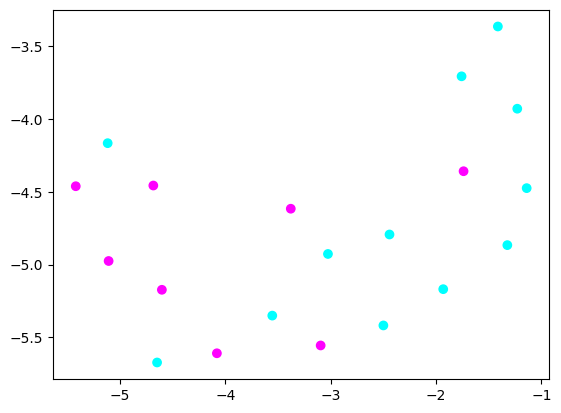

In [30]:
from umap import UMAP

umap = UMAP(n_components=2, random_state=42)
umap_features = umap.fit_transform(features)

import matplotlib.pyplot as plt
plt.scatter(umap_features[:, 0], umap_features[:, 1], c=test_labels, cmap='cool')
plt.show()

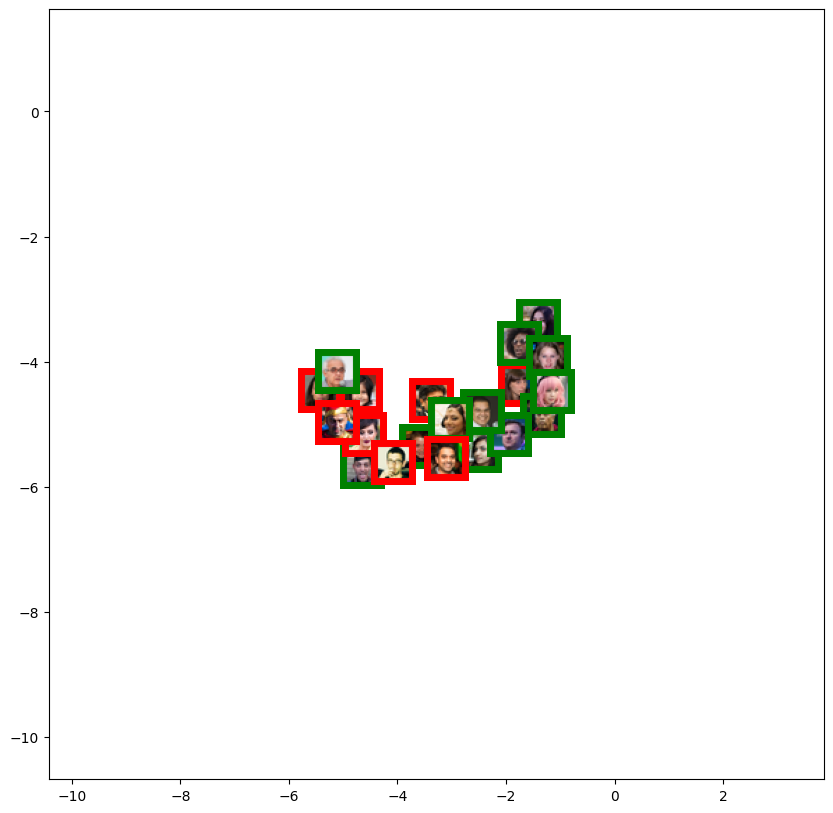

In [53]:
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox

fig, ax = plt.subplots(figsize=(10, 10))

# Scaling factor to control the size of the displayed images
scale_factor = 0.1
border_thickness = 5

for i, (x, y) in enumerate(umap_features):
    image = test_images[i].astype(np.uint8)
    img = Image.fromarray(image)
    img.thumbnail((image.shape[1] * scale_factor, image.shape[0] * scale_factor), Image.ANTIALIAS)
    
    # Add a colored border around the image
    border_color = 'red' if test_labels[i] == 1 else 'green'
    bordered_image = Image.new('RGB', (img.width + 2 * border_thickness, img.height + 2 * border_thickness), border_color)
    bordered_image.paste(img, (border_thickness, border_thickness))
    
    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(bordered_image), (x, y), frameon=False)
    ax.add_artist(imagebox)

ax.set_xlim(umap_features[:, 0].min() - 5, umap_features[:, 0].max() + 5)
ax.set_ylim(umap_features[:, 1].min() - 5, umap_features[:, 1].max() + 5)

plt.show()


In [34]:
# Add this code after the line where you define `sample_paths`:

original_images = []
for i, path in enumerate(sample_paths):
    img = s3.Object(bucket_name, path)
    img = Image.open(img.get()['Body'])
    img = np.array(img)
    img = tf.cast(img, dtype=tf.uint8)
    original_images.append(img)

original_images = np.stack(original_images)


NameError: name 'border_thickness' is not defined

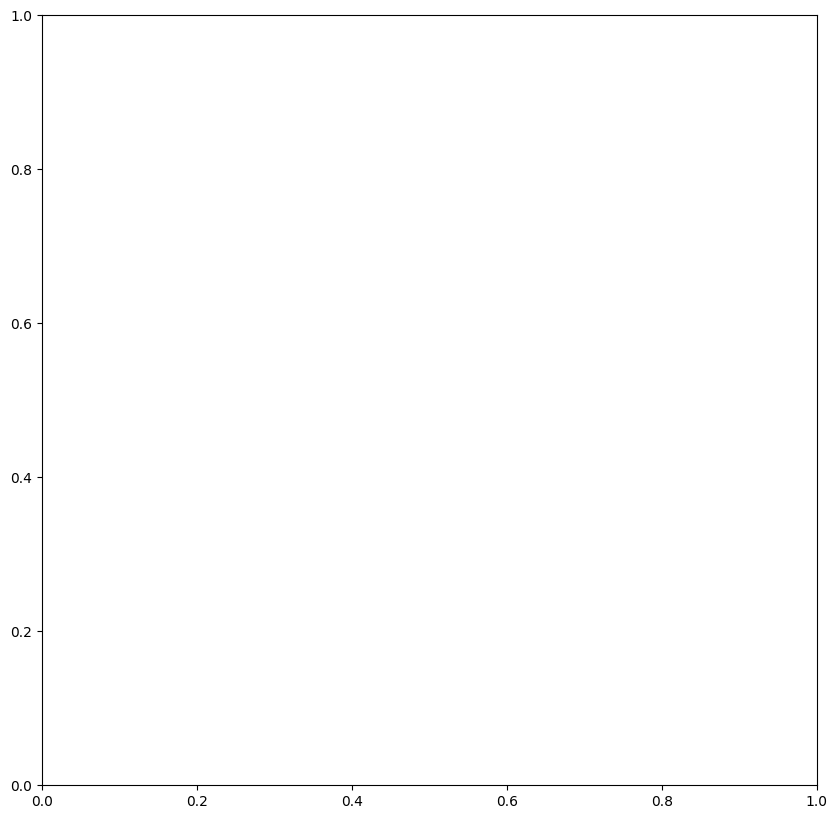

In [52]:
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox

fig, ax = plt.subplots(figsize=(10,10))

# Scaling factor to control the size of the displayed images
scale_factor = 0.02
border_thickness = 5
for i, (x, y) in enumerate(umap_features):
    image = original_images[i]
    img = Image.fromarray(image)
    img.thumbnail((image.shape[1] * scale_factor, image.shape[0] * scale_factor), Image.ANTIALIAS)
    
    # Add a colored border around the image
    border_color = 'red' if test_labels[i] == 1 else 'green'
    bordered_image = Image.new('RGB', (img.width + 2 * border_thickness, img.height + 2 * border_thickness), border_color)
    bordered_image.paste(img, (border_thickness, border_thickness))
    
    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(bordered_image), (x, y), frameon=False)
    ax.add_artist(imagebox)
    
ax.set_xlim(umap_features[:, 0].min() - 5, umap_features[:, 0].max() + 5)
ax.set_ylim(umap_features[:, 1].min() - 5, umap_features[:, 1].max() + 5)

plt.show()


In [29]:
# # Extract the features from the trained model for t-SNE visualization
# features = model.predict(test_images)

# # Use t-SNE to reduce the dimensionality of the feature vectors to 2D
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, verbose=1, perplexity=5)
# tsne_features = tsne.fit_transform(features)
# # Plot the t-SNE features with different colors for real and fake images
# import matplotlib.pyplot as plt
# plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=test_labels, cmap='cool')
# plt.show()

1/1 [==============================] - 0s 221ms/step
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.000s...
[t-SNE] Computed neighbors for 20 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 0.005206


ValueError: n_components=2 must be between 1 and min(n_samples, n_features)=1 with svd_solver='randomized'